# Final Scenario Discovery

## 0 Setup

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [49]:
######## Problem Formulation
pf = 7
#n_scenario = 2**8
#n_policy = 64

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

In [3]:
# Load Results
results = load_results(f'results/robustness_results.tar.gz')

# Extracting the results
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\robustness_results.tar.gz


In [4]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1,scenario,policy,model
0,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,...,0,5,5,0,0,0,0,0,0,dikesnet
1,62,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,...,0,5,5,0,0,0,0,1,0,dikesnet
2,63,171.904728,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,...,0,5,5,0,0,0,0,2,0,dikesnet
3,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,...,0,5,5,0,0,0,0,3,0,dikesnet
4,63,295.565713,1.5,0.211014,33.257357,1.0,0.488959,288.873509,1.5,0.270206,...,0,5,5,0,0,0,0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126459,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,...,0,5,0,5,0,5,0,9723,12,dikesnet
126460,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,...,0,5,0,5,0,5,0,9724,12,dikesnet
126461,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,...,0,5,0,5,0,5,0,9725,12,dikesnet
126462,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,...,0,5,0,5,0,5,0,9726,12,dikesnet


In [5]:
126464/13

9728.0

In [6]:
outcomes.keys()

dict_keys(['A.4_Total Costs', 'A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 'A.5_Total Costs', 'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [18]:
# Group experiments and outcomes by 'policy' column
policy_groups = experiments.groupby('policy')

# Create lists to store separated datasets
experiments_list = []
outcomes_list = []

for policy, group in policy_groups:
    # drop levers
    group.drop(columns=list(model.levers.keys()), inplace=True, errors='ignore')
    group.drop(columns=["policy", "scenario", "model"], inplace=True, errors='ignore')

    # Store experiments for this policy
    experiments_list.append(group)

    # Store outcomes for this policy
    indices = group.index
    policy_outcomes = {k: v[indices] for k, v in outcomes.items()}
    outcomes_list.append(policy_outcomes)

C:\Users\Move\AppData\Local\Temp\ipykernel_15880\2754433037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  policy_groups = experiments.groupby('policy')


In [24]:
len(experiments_list), len(outcomes_list)

# print the size of all experiments and outcomes
for i, (exp, out) in enumerate(zip(experiments_list, outcomes_list)):
    print(f"Policy {i}:")
    print(f"  Experiments shape: {exp.shape}")
    print(f"  Outcomes shape: {len(out)}")
    for k, v in out.items():
        print(f"    {k}: {v.shape if isinstance(v, np.ndarray) else type(v)}")

Policy 0:
  Experiments shape: (9728, 18)
  Outcomes shape: 10
    A.4_Total Costs: (9728,)
    A.4_Dike Investment Costs: (9728,)
    A.4_Expected Annual Damage: (9728,)
    A.4_Expected Number of Deaths: (9728,)
    A.5_Total Costs: (9728,)
    A.5_Dike Investment Costs: (9728,)
    A.5_Expected Annual Damage: (9728,)
    A.5_Expected Number of Deaths: (9728,)
    RfR Total Costs: (9728,)
    Expected Evacuation Costs: (9728,)
Policy 1:
  Experiments shape: (9728, 18)
  Outcomes shape: 10
    A.4_Total Costs: (9728,)
    A.4_Dike Investment Costs: (9728,)
    A.4_Expected Annual Damage: (9728,)
    A.4_Expected Number of Deaths: (9728,)
    A.5_Total Costs: (9728,)
    A.5_Dike Investment Costs: (9728,)
    A.5_Expected Annual Damage: (9728,)
    A.5_Expected Number of Deaths: (9728,)
    RfR Total Costs: (9728,)
    Expected Evacuation Costs: (9728,)
Policy 2:
  Experiments shape: (9728, 18)
  Outcomes shape: 10
    A.4_Total Costs: (9728,)
    A.4_Dike Investment Costs: (9728,)
   

In [25]:
experiments_list[0]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1
0,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
1,62,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
2,63,171.904728,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
3,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
4,63,295.565713,1.5,0.211014,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,1.0,0.327383,2.5,3.5
9724,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.211165,2.5,3.5
9725,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.327383,1.5,3.5
9726,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.327383,2.5,1.5


In [26]:
experiments_list[1]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1
9728,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
9729,62,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
9730,63,171.904728,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
9731,63,295.565713,1.5,0.089396,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
9732,63,295.565713,1.5,0.211014,33.257357,1.0,0.488959,288.873509,1.5,0.270206,325.081314,1.5,0.690227,147.416323,10.0,0.759438,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19451,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,1.0,0.327383,2.5,3.5
19452,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.211165,2.5,3.5
19453,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.327383,1.5,3.5
19454,129,37.761733,1.0,0.251519,212.613627,10.0,0.785394,85.608062,1.0,0.353175,291.465980,10.0,0.414772,217.670547,10.0,0.327383,2.5,1.5


## Discover worst case scenarios

Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [50]:
list(model.outcomes.keys())

['A.4_Total Costs',
 'A.4_Dike Investment Costs',
 'A.4_Expected Annual Damage',
 'A.4_Expected Number of Deaths',
 'A.5_Total Costs',
 'A.5_Dike Investment Costs',
 'A.5_Expected Annual Damage',
 'A.5_Expected Number of Deaths',
 'RfR Total Costs',
 'Expected Evacuation Costs']

[MainProcess/INFO] 9728 points remaining, containing 627 cases of interest
[MainProcess/INFO] mean: 0.7338551859099804, mass: 0.05252878289473684, coverage: 0.5980861244019139, density: 0.7338551859099804 restricted_dimensions: 6
[MainProcess/INFO] 9728 points remaining, containing 627 cases of interest
[MainProcess/INFO] mean: 0.7338551859099804, mass: 0.05252878289473684, coverage: 0.5980861244019139, density: 0.7338551859099804 restricted_dimensions: 6
[MainProcess/INFO] 9728 points remaining, containing 627 cases of interest
[MainProcess/INFO] mean: 0.7338551859099804, mass: 0.05252878289473684, coverage: 0.5980861244019139, density: 0.7338551859099804 restricted_dimensions: 6
[MainProcess/INFO] 9728 points remaining, containing 424 cases of interest
c:\Users\Move\anaconda3\envs\abm24\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype i

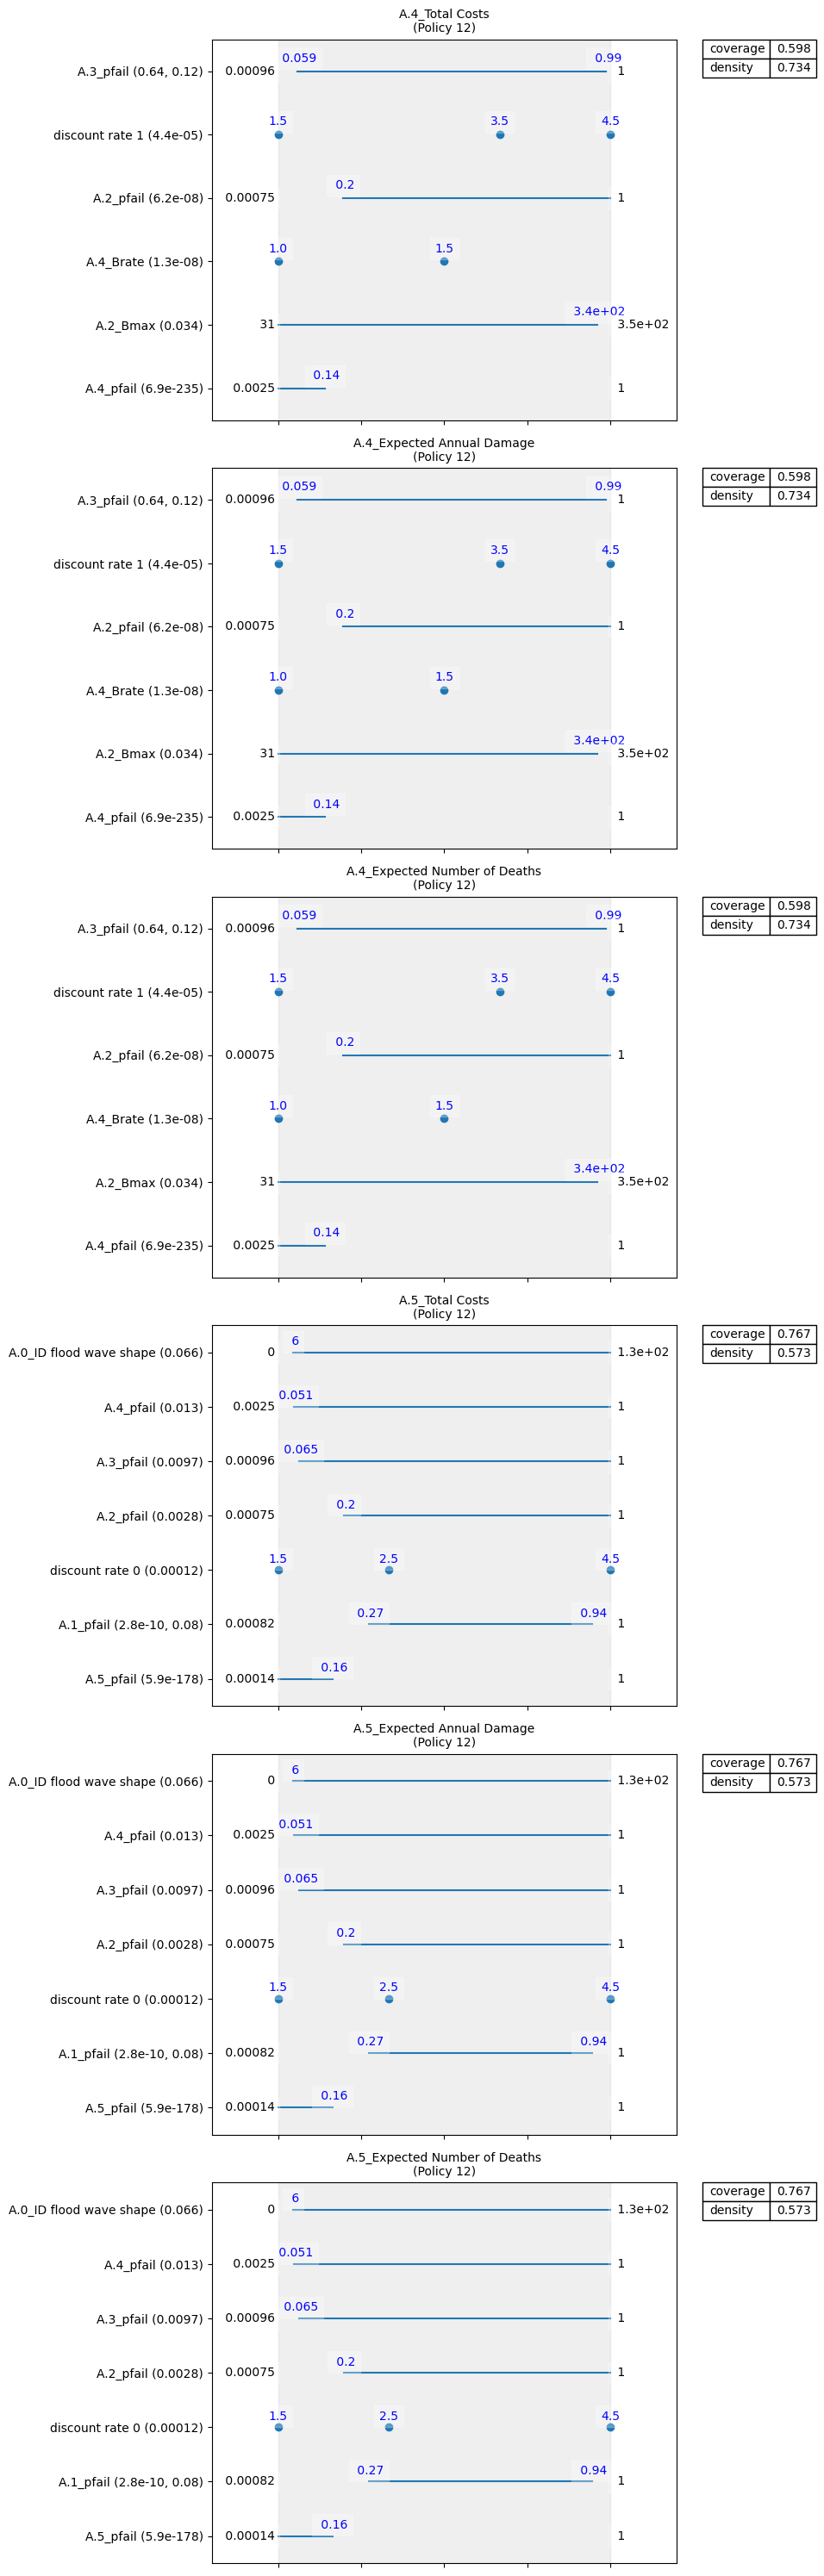

In [75]:
## show all result: Expected Number of Deaths

from ema_workbench.analysis import prim

# plot detail
outcomes_names = ['A.4_Total Costs',
                  'A.4_Expected Annual Damage', 
                  'A.4_Expected Number of Deaths', 
                  'A.5_Total Costs',
                  'A.5_Expected Annual Damage', 
                  'A.5_Expected Number of Deaths',]

dike_percentile = 10  # Percentiles for worst case analysis
dike_thresholds = 0.5 # Thresholds for PRIM analysis
policy_idx = 12  # Index of the policy to analyze

fig, axes = plt.subplots(6, 1, figsize=(10, 30))
for i, ax in enumerate(axes):
    outcome_name = outcomes_names[i]
    data = outcomes_list[policy_idx][outcome_name]
    y = data > np.percentile(data, dike_percentile)
    prim_alg = prim.Prim(experiments_list[policy_idx], y, threshold=dike_thresholds, peel_alpha=0.05)
    box = prim_alg.find_box()
    box.inspect(style='graph', ax=ax)
    ax.set_title(f'{outcome_name}\n(Policy {policy_idx})', fontsize=10)
plt.tight_layout()
plt.show()

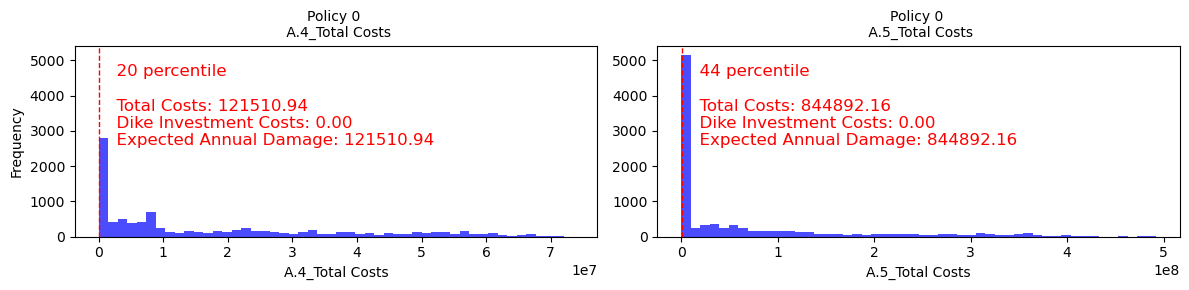

[MainProcess/INFO] 9728 points remaining, containing 7772 cases of interest
c:\Users\Move\anaconda3\envs\abm24\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.48355263157894735, coverage: 0.6052496139989707, density: 1.0 restricted_dimensions: 4
[MainProcess/INFO] 9728 points remaining, containing 5442 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.22512335526315788, coverage: 0.402425578831312, density: 1.0 restricted_dimensions: 4


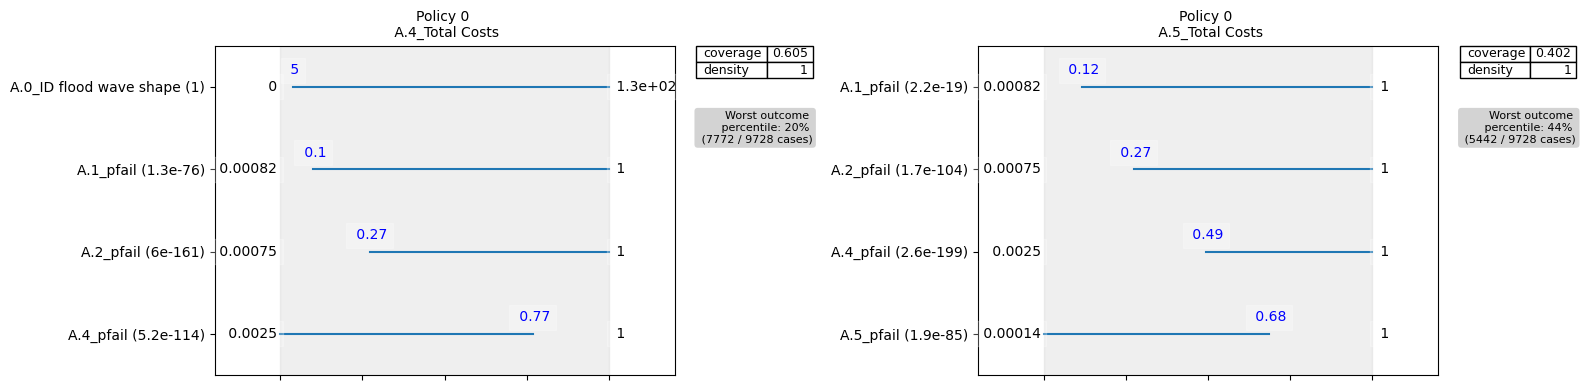

In [370]:
## show all result: Expected Number of Deaths

from ema_workbench.analysis import prim

# plot detail
dike_names = ['A.4', 'A.5']  # Dike names corresponding to the outcomes

dike_percentile = [20, 44]  # Percentiles for worst case analysis
dike_thresholds = 0.3 # Thresholds for PRIM analysis
policy_idx = 0  # Index of the policy to analyze

# Plot histograms with the same y-axis limits for both subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
hist_max = 0
# First, find the maximum y value across all histograms
for i in range(len(axes)):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    counts, _ = np.histogram(data, bins=50)
    hist_max = max(hist_max, counts.max())

for i, ax in enumerate(axes):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    data_2 = outcomes_list[policy_idx][dike_names[i] + '_Dike Investment Costs']
    data_3 = outcomes_list[policy_idx][dike_names[i] + '_Expected Annual Damage']
    ax.hist(data, bins=50, color='blue', alpha=0.7)
    ax.axvline(np.percentile(data, dike_percentile[i]), color='red', linestyle='dashed', linewidth=1)
    ax.annotate(f"  {dike_percentile[i]} percentile \n\n  Total Costs: {np.percentile(data, dike_percentile[i]):.2f} \n  Dike Investment Costs: {np.percentile(data_2, dike_percentile[i]):.2f} \n  Expected Annual Damage: {np.percentile(data_3, dike_percentile[i]):.2f}", 
                xy=(np.percentile(data, dike_percentile[i]), hist_max * 0.95), 
                xytext=(5, 0), textcoords='offset points',
                color='red', fontsize=12, va='top', ha='left', rotation=0)
    ax.set_title(f'Policy {policy_idx} \n {outcome_name}', fontsize=10)
    ax.set_xlabel(outcome_name)
    if i == 0:
        ax.set_ylabel('Frequency')
    ax.set_ylim(0, hist_max * 1.05)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for i, ax in enumerate(axes):
    outcome_name = dike_names[i] + '_Total Costs'
    data = outcomes_list[policy_idx][outcome_name]
    y = data > np.percentile(data, dike_percentile[i])
    prim_alg = prim.Prim(experiments_list[policy_idx], y, threshold=dike_thresholds, peel_alpha=0.05)
    box = prim_alg.find_box()
    box.inspect(style='graph', ax=ax)
    ax.set_title(f'Policy {policy_idx} \n {outcome_name}', fontsize=10)
    # add annotation of dike threshold and dike percentile on the right side of the plot
    ax.annotate(f'Worst outcome \n percentile: {dike_percentile[i]}% \n ({np.sum(y)} / {len(data)} cases)', 
                xy=(1.3, 0.7), xycoords='axes fraction', 
                fontsize=8, ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='None', facecolor='lightgrey'))
plt.tight_layout()
plt.show()